In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# Initialise parameters:
num_of_agents = 100 # number of agents
Timesteps = 500 # timesteps (1 = no steps taken)
R = 0.2 # confidence bound


min_age = 16
max_age = 81
op_drift = 0.01

youth_min_op = 0
youth_max_op = 0.4

In [58]:
opinions = np.random.rand(num_of_agents) # init all agents to [0,1]
ages = np.random.randint(min_age,max_age, size=num_of_agents) 

In [59]:
def get_A(opinions,R):
    '''
    A function to return the average opinion within R of each opinion in a vector of opinions
    '''
    
    # Create a square matrix consisting of the opinions vector repeated num_of_agents times
    opinions_repeated = np.array([opinions]*len(opinions))
    # Create matrix of boolean values indicating which opinions are within R of each opinion
    mask = abs(opinions_repeated - opinions_repeated.T) < R
    
    # Initialise averages matrix
    A = np.zeros(num_of_agents)

    # Loop over agents
    for i in range(num_of_agents):
        # Get average of opinions within R of opinion
        A[i] = np.mean(opinions[mask[i,:]])
        # print(A[i])
    
    return(A)

In [ ]:
# Running model

# Initialising matrix of opinions over time
opinions_over_time = np.zeros((Timesteps, num_of_agents))
opinions_over_time[0,:] = opinions
# Initialising matrix of ages over time
ages_over_time = np.zeros((Timesteps,num_of_agents))
ages_over_time[0,:] = ages


for t in range(Timesteps-1):
    # Basic opinion update (minimum necesssary to keep opinions within a range)
    opinions_over_time[t+1,:] = np.minimum(get_A(opinions_over_time[t,:], R) + op_drift, 1.0)

    # Update ages
    ages_over_time[t+1,:] = ages_over_time[t,:] + 1
    
    # Find who dies at next step
    deaths = ages_over_time[t+1,:] > max_age
    num_deaths = sum(deaths)

    # Replace the people who die with young people
    ages_over_time[t+1, deaths] = min_age

    # Initialise new people with uniformly distributed opinions within some range
    opinions_over_time[t+1,:][deaths] = (youth_max_op - youth_min_op) * np.random.random(num_deaths) + youth_min_op 
    
    
print(opinions_over_time)
print(ages_over_time)

[[0.66370723 0.61831444 0.26532818 ... 0.78921024 0.0265089  0.48562541]
 [0.66712431 0.6118632  0.27425924 ... 0.78830916 0.11664503 0.48320718]
 [0.6901534  0.62167633 0.29228199 ... 0.77077532 0.19926772 0.47289009]
 ...
 [0.58086578 0.58086578 0.58086578 ... 0.1143009  1.         0.58086578]
 [0.59086578 0.59086578 0.59086578 ... 0.24117843 1.         0.59086578]
 [0.60086578 0.60086578 0.60086578 ... 0.25117843 1.         0.60086578]]
[[16. 31. 28. ... 47. 43. 33.]
 [17. 32. 29. ... 48. 44. 34.]
 [18. 33. 30. ... 49. 45. 35.]
 ...
 [51. 66. 63. ... 16. 78. 68.]
 [52. 67. 64. ... 17. 79. 69.]
 [53. 68. 65. ... 18. 80. 70.]]


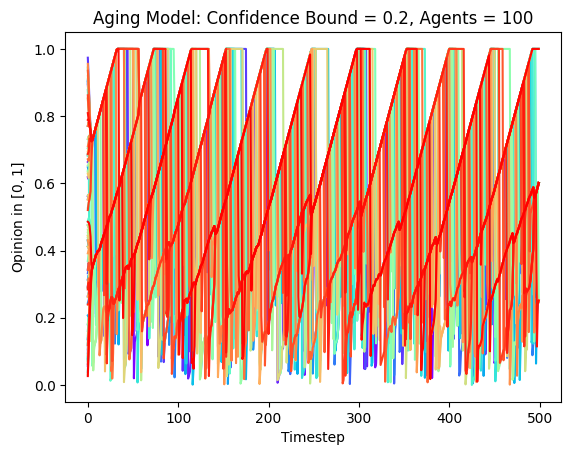

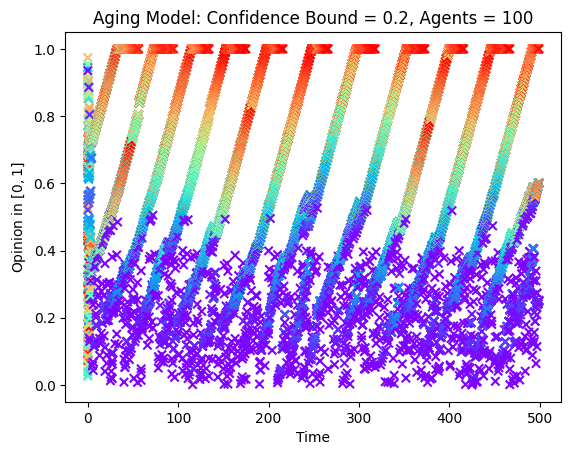

In [61]:
#plotting

colours = plt.cm.rainbow(np.linspace(0,1,num_of_agents))

for i in range(num_of_agents):
    plt.plot(opinions_over_time[:,i],color=colours[i])
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Timestep')
plt.ylabel('Opinion in $[0,1]$')
plt.show()

#plotting

colours = plt.cm.rainbow(np.linspace(0,1,round(max_age-min_age+1)))
plt.scatter(np.array([range(Timesteps)]*num_of_agents).T, opinions_over_time, c=ages_over_time, cmap='rainbow', marker='x')
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Time')
plt.ylabel('Opinion in $[0,1]$')
plt.show()

